In [1]:
""" Unstructured finite volume code for hyperbolic problems"""
"""Shallow Water Dam Break in this case"""

Mounted at /content/drive


In [3]:
import torch
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math


# Godunov Solver

In [4]:
# get the required fields from the mesh and convert to tensor
def create_msh(loaded_msh,dattype = torch.float32):
  # key1 = list(loaded_msh.keys())[-1]
  key1 = list(loaded_msh.keys())[-2]
  msh = {}
  msh['e2e'] = torch.tensor(loaded_msh[key1]['e2e'][0][0])-1
  msh['porder'] = loaded_msh[key1]['porder'][0][0][0][0]
  msh['ndim'] = loaded_msh[key1]['ndim'][0][0][0][0]
  msh['e2bnd'] = torch.tensor(loaded_msh[key1]['e2bnd'][0][0])
  msh['transf_data'] = {}
  msh['transf_data']['xc'] = torch.tensor(loaded_msh[key1]['transf_data'][0][0]['xc'][0][0]).to(dattype)
  msh['transf_data']['Nf'] = torch.tensor(loaded_msh[key1]['transf_data'][0][0]['Nf'][0][0]).to(dattype)
  msh['transf_data']['vf'] = torch.tensor(loaded_msh[key1]['transf_data'][0][0]['vf'][0][0]).to(dattype)
  msh['transf_data']['ve'] = torch.tensor(loaded_msh[key1]['transf_data'][0][0]['ve'][0][0]).to(dattype).permute(1,0)
  return msh

In [5]:
def eval_vel_fvm_unstructured(t, Q, msh, numflux_fcn, parameters, bctype):
    elem2elem = msh['e2e']
    num_variable = Q.size(-1)  # Obtain the size of the last dimension
    num_face_elem = elem2elem.size(1)
    num_elems = elem2elem.size(2)

    x_cc = msh['transf_data']['xc']
    num_dims = x_cc.size(0)
    f_norm = msh['transf_data']['Nf']
    fc_area = msh['transf_data']['vf']
    el_vol = msh['transf_data']['ve']


    # Q_in = torch.zeros(num_variable, num_face_elem, num_elems)
    # Q_out = torch.zeros(num_variable, num_face_elem, num_elems)
    # for el_idx in range(num_elems):
    #   for fc_idx in range(num_face_elem):
    #       Q_in[:,fc_idx, el_idx] = Q[el_idx]
    #       elem_neigh = elem2elem[0, fc_idx, el_idx]
    #       if not torch.isnan(elem_neigh):
    #           Q_out[:,fc_idx, el_idx] = Q[elem_neigh.to(torch.int64)]


    Q_out = torch.zeros(num_variable,num_elems,num_face_elem)
    # pdb.set_trace()
    # Create meshgrid of indices
    el_idx, fc_idx = torch.meshgrid(torch.arange(num_elems), torch.arange(num_face_elem), indexing='ij')

    # pdb.set_trace()
    Q_in = Q[el_idx,:].permute(2,1,0)
    # Assign values to Q_in
    elem_neigh = elem2elem[0, fc_idx, el_idx]

    # Mask elements with NaN neighbors
    valid_mask = ~torch.isnan(elem_neigh)

    # Assign values to Q_out for valid neighbors
    Q_out[:,valid_mask] = Q[elem_neigh[valid_mask].to(torch.int64)].permute(1,0)
    Q_out = Q_out.permute(0,2,1)


    int_face_idx = torch.isnan(msh['e2bnd'].permute(1,0).reshape(-1))

    Q_in = Q_in.permute(0,2,1).reshape(num_variable,-1).permute(1,0)
    Q_out = Q_out.permute(0,2,1).reshape(num_variable,-1).permute(1,0)
    f_norm = f_norm.permute(0,2,1).reshape(num_dims,-1).permute(1,0)
    flux_face = torch.zeros(num_elems * num_face_elem, num_variable)


    flux_face[int_face_idx] = numflux_fcn(Q_in[int_face_idx], Q_out[int_face_idx], f_norm[int_face_idx])
    # pdb.set_trace()
    if bctype == 'euler_pentexp':
      bnd_face_idx = ~int_face_idx
      rho_bnd = Q_in[bnd_face_idx, 0:1]
      vel_bnd = Q_in[bnd_face_idx, 1:-1] / rho_bnd
      Pressure = (parameters['gamma'] - 1) * (Q_in[bnd_face_idx, -1:] - 0.5 * rho_bnd * (torch.sum(vel_bnd ** 2, dim=-1).unsqueeze(-1)))
      flux_face[bnd_face_idx] = torch.cat((torch.zeros_like(rho_bnd), Pressure * f_norm[bnd_face_idx], torch.zeros_like(rho_bnd)), dim=-1)

    elif bctype == 'swe_circdam':
      bnd_face_idx = ~int_face_idx
      rho_bnd = Q_in[bnd_face_idx, 0:1]
      flux_face[bnd_face_idx] = torch.cat((torch.zeros_like(rho_bnd), 0.5*(rho_bnd**2) * f_norm[bnd_face_idx]), dim=-1)

    flux_intface = flux_face.permute(1,0).reshape(num_variable,num_elems,-1).permute(0,2,1)*fc_area.unsqueeze(0)
    # flux_intface = flux_face.view(num_face_elem,-1, num_variable) * fc_area.unsqueeze(-1)
    flux_summed = torch.sum(flux_intface, dim=1).permute(1,0)
    flux_invis = - flux_summed/ el_vol

    return flux_invis

In [6]:
def advance_ode_nonlin_rk4(y_n, t, dt, F):
  f1 = F(t,y_n);
  f2 = F(t+dt/2,y_n+(dt/2)*f1);
  f3 = F(t+dt/2,y_n+(dt/2)*f2);
  f4 = F(t+dt,y_n+dt*f3);

  y_np1 = y_n + (dt/6)*(f1+2*f2+2*f3+f4);
  return y_np1

def advance_ode_nonlin_feuler(y_n, t, dt, F):
  y_np1 = y_n + dt*F(t,y_n)
  return y_np1

In [7]:
def run_sim_rk4_fvm(Q0,msh,nstep,dt,numflux_fcn,parameters,bctype):
  Q_store = []
  Q_store.append(Q0[:,:,None])
  Q = Q0
  eval_vel_partial = lambda t,Q: eval_vel_fvm_unstructured(t,Q,msh,numflux_fcn,parameters,bctype)
  for tstep in range(nstep):
    if tstep%20==0:
      print(f'time step - {tstep}\n')
    # pdb.set_trace()
    Q = advance_ode_nonlin_feuler(Q,0,dt,eval_vel_partial)
    Q_store.append(Q[:,:,None])
  return Q_store

In [8]:
def pospart_torch(x):
      return torch.maximum(torch.tensor(1.e-14),x)

def flux_fcn_swe(q,f_norm):
  vel = q[:,1:]/pospart_torch(q[:,:1]);
  rhovN = torch.sum(q[:,1:]*f_norm,dim=-1).unsqueeze(-1);
  flux_euler = torch.concatenate((rhovN,vel*rhovN + 0.5*(q[:,:1]**2)*f_norm),dim=-1);
  return flux_euler

In [9]:
def eval_numflux_hll_ndim(ql, qr, smin, smax,f_norm, flux_fcn):
    # Left/right fluxes
    fl = flux_fcn(ql,f_norm)
    fr = flux_fcn(qr,f_norm)

    # HLL flux
    idx0 = (torch.squeeze(smin) >= 0)
    idx1 = (torch.squeeze(smax) <= 0)
    idx2 = torch.logical_and((torch.squeeze(smin) < 0), (torch.squeeze(smax) > 0))

    fs = torch.zeros_like(fl)

    # Set values for each case
    fs[idx0,:] = fl[idx0,:]
    fs[idx1,:] = fr[idx1,:]

    fs1 = ((fl * smax) - (fr * smin) + ((qr - ql) * smin * smax))/(smax-smin)
    fs[idx2,:] = fs1[idx2,:]
    return fs

In [10]:
def eval_numflux_hll_swe(ql,qr,f_norm, gamma=1.4):

  #Extract left/right states
  rho_l = ql[:,0:1]; rho_r = qr[:,0:1];
  ul = ql[:, 1:]/rho_l; ur = qr[:,1:]/rho_r;

  # Wave speeds from Roe averages
  vavg = (torch.sqrt(rho_l)*ul+torch.sqrt(rho_r)*ur)/(torch.sqrt(rho_l)+torch.sqrt(rho_r));
  rho_avg =0.5* (rho_l + rho_r);
  cavg = torch.sqrt(rho_avg);

  # Compute flux
  smin = torch.sum(vavg*f_norm,dim=-1).unsqueeze(-1) - cavg;
  smax = torch.sum(vavg*f_norm,dim=-1).unsqueeze(-1) + cavg;

  fs = eval_numflux_hll_ndim(ql, qr, smin, smax,f_norm, flux_fcn_swe);
  return fs

In [11]:
#load mesh
loaded_msh = sio.loadmat('cartmshsquare10.mat')
msh = create_msh(loaded_msh,dattype=torch.float32)

In [12]:
Time_end = 2;
dt    = 0.01;
nstep = int(Time_end/dt);


x_c = msh['transf_data']['xc']
# Setting parameter
bctype     = 'swe_circdam'
parameters = {'g': 1.0}


#initial condition
domain = ((x_c[0,:] - 5)** 2 + (x_c[1,:] - 5)** 2 <= (2.5 ** 2)).reshape(-1,1)
rho_0  = parameters['g']*3*domain + parameters['g']*0.25*(~domain)
v1_0   = torch.zeros_like(rho_0)
v2_0   = torch.zeros_like(rho_0)
Q0     = torch.cat((rho_0, rho_0 * v1_0, rho_0 * v2_0), dim=-1)

In [13]:
Q_hll = run_sim_rk4_fvm(Q0,msh,nstep,dt,eval_numflux_hll_swe,parameters,bctype)

time step - 0

time step - 20

time step - 40

time step - 60

time step - 80

time step - 100

time step - 120

time step - 140

time step - 160

time step - 180



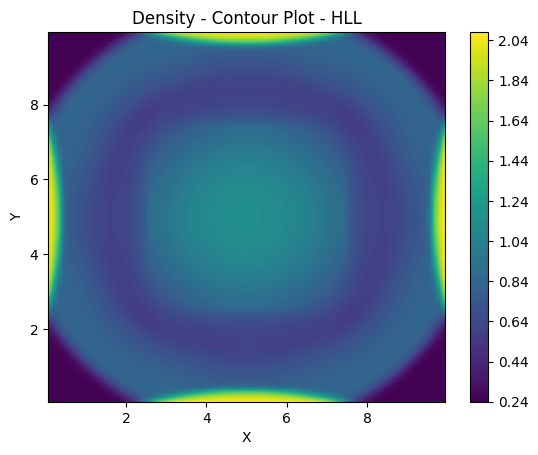

In [14]:
Q_hll_full = torch.concatenate(Q_hll,dim=-1)

plt.tricontourf(x_c[0,:], x_c[1,:], Q_hll_full[:,0,-1], cmap='viridis',levels=100)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Density - Contour Plot - HLL')
plt.colorbar()